In [1]:
import os
os.chdir('/mnt/data/akshit.jain/user_clicks/')

In [2]:
import pandas as pd
import fastavro
import numpy as np

def avro_df(filepath, encoding='rb'):
    # Open file stream
    with open(filepath, encoding) as fp:
        # Configure Avro reader
        reader = fastavro.reader(fp)
        # Load records in memory
        records = [r for r in reader]
        # Populate pandas.DataFrame with records
        df = pd.DataFrame.from_records(records)
        # Return created DataFrame
        return df

In [13]:
df=avro_df('clicks_visual_stores.avro')

In [18]:
[print("http://www.flipkart.com/item/{}".format(f)) for f in df[df.userId=='03231c7e3b6ab49274b71ff2968708ce'].fsn.tolist()]

http://www.flipkart.com/item/RPTEEGVZPFSK8JPJ
http://www.flipkart.com/item/DDHFFDFWZT3XHNEP
http://www.flipkart.com/item/DDHFYGZHPK5FWE8G
http://www.flipkart.com/item/RPTF4A9UYWS2TYVB


[None, None, None, None]

In [4]:
STORE='mgl'
store_df = df[df.store.str.contains(STORE)]

In [5]:
import os
import os.path as osp
save_dir='category_data/'+'_'.join(STORE.split('/'))
os.makedirs(save_dir, exist_ok=True)
store_df.to_pickle(osp.join('raw_user_click_df.pk'))

## Populalte with fsn metadata

In [128]:
import requests as R
import json
import itertools
import traceback

BATCH_SIZE=200

def fetch_from_api(fsns):
    uri="http://10.47.2.116:31100/views/product_base_info?entityIds={}".format(','.join(fsns))
    resp = R.get(uri)
    return resp.json()

def parse_product_info(resp):
    fsn = resp['entityId']
    try:
        resp = resp['view']
        image_id = resp['primary_image_id']
        image=[x for x in resp['product_images'] if x['id']==image_id][0]['url']
        title=resp['titles']['w3_title']
    except KeyError:
        image=''
        title=''
        print("failed for ", fsn)
        return
    return {'fsn':fsn,'url':image,'title':title}

def parse_response(resp):
    return [parse_product_info(x) for x in resp['entityViews']]

def get_fsns_images(fsn_df):
    print("batch: {}".format(fsn_df.name))
    try:
        fsns = fsn_df.fsn.tolist()
        resp = fetch_from_api(fsns)
        return parse_response(resp)
    except Exception as e:
        print('failed!!!')
        print(e)
        return []

def batch_and_get_images(fsns):
    fdf=pd.DataFrame(fsns, columns=['fsn'])
    fdf['batch']=fdf.index//BATCH_SIZE
    print("starting fetch for {} batches".format(len(fdf.batch.unique())))
    image_urls = fdf.groupby('batch').apply(get_fsns_images)
    return pd.DataFrame(list(itertools.chain.from_iterable(image_urls.tolist())))

In [115]:
%%time
fsn_meta=batch_and_get_images(store_df.fsn.unique())

starting fetch for 202 batches
batch: 185
batch: 185
CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 1.76 s


In [7]:
# fsn_meta.to_pickle(osp.join(save_dir, 'fsn_meta.pk'))
fsn_meta=pd.read_pickle(osp.join(save_dir, 'fsn_meta.pk'))
fsn_meta.reset_index(drop=True, inplace=True)

In [139]:
fsn_meta.head()

,fsn,title,url
0,VPAECBWQMRXHSYZ6,Hot Wheels Mattel K5904 Hot Wheels (3 pack) (C...,http://img.fkcdn.com/image/vehicle-pull-along/...
1,STFESQYTPEZE2MRH,Tinytot TBB_001 - 12 inch,http://img.fkcdn.com/image/j12gakw0/stuffed-to...
2,SPLEGMWTBNVWGRHY,Rapidity Ldrago Destroy Beyblade with Launcher,http://img.fkcdn.com/image/spin-press-launch-t...
3,PNCFY9KQVZT7ZVWJ,Faber-Castell 6 Bi Colour Pencils Pencil,http://img.fkcdn.com/image/jh80ia80/pencil/v/w...
4,BLCDUWGFDYDJ5FQK,Ratnas Genius Block,http://img.fkcdn.com/image/block-construction/...


# Download images

In [6]:
import urllib
from urllib.parse import urlparse
import subprocess as sp
import os.path as osp
# max width x height supported on tf hub modules are 224-331 so we will go with 300 for now
IMAGE_DIM=300
BATCH_SIZE=100
images_dir=osp.join(save_dir,'product_images')
os.makedirs(images_dir, exist_ok=True)

def get_fsn_image_path(fsn):
    return osp.join(images_dir, fsn+'.jpg')

def get_dynamic_url(static_url):
    path=urlparse(static_url).path
    path=path.replace('/image/','')
    HOST="http://rukminim1.flixcart.com/image"
    return "{0}/@width/@height/{1}?q=@quality".format(HOST, path)

def get_res_image(url, width, height, quality=100, is_static=True):
    if is_static:
        url=get_dynamic_url(url)
    return url.replace('@width', str(width)).replace('@height', str(height)).replace("@quality", str(quality))

def single_batch_download(fsns):
    print("downloading batch: {}".format(fsns.name))
    def image_download(fsn, url):
        img_uri=get_res_image(url, IMAGE_DIM, IMAGE_DIM)# fsn_info['image']['url'].replace('{@width}', str(IMAGE_DIM)).replace('{@height}', str(IMAGE_DIM)).replace('{@quality}', str(100))
        dump_file=get_fsn_image_path(fsn)
        if osp.exists(dump_file):
            return
        cmd="curl -o {0} '{1}' &".format(dump_file, img_uri)
        sp.call(cmd, shell=True)
    fsns.apply(lambda x: image_download(x.fsn, x.url), axis=1)

def batch_and_download(fsn_image):
    fsn_image['partition'] = fsn_image.index//BATCH_SIZE
    print("total batches: {}".format(fsn_image.partition.unique().shape))
    fsn_image.groupby('partition').apply(single_batch_download)


In [ ]:
batch_and_download(fsn_meta[['fsn','url']])

total batches: (604,)
downloading batch: 0
downloading batch: 0
downloading batch: 1
downloading batch: 2
downloading batch: 3
downloading batch: 4
downloading batch: 5
downloading batch: 6
downloading batch: 7
downloading batch: 8
downloading batch: 9
downloading batch: 10
downloading batch: 11
downloading batch: 12
downloading batch: 13
downloading batch: 14
downloading batch: 15
downloading batch: 16
downloading batch: 17
downloading batch: 18
downloading batch: 19
downloading batch: 20
downloading batch: 21
downloading batch: 22
downloading batch: 23
downloading batch: 24
downloading batch: 25
downloading batch: 26
downloading batch: 27
downloading batch: 28
downloading batch: 29
downloading batch: 30
downloading batch: 31
downloading batch: 32
downloading batch: 33
downloading batch: 34
downloading batch: 35
downloading batch: 36
downloading batch: 37
downloading batch: 38
downloading batch: 39
downloading batch: 40
downloading batch: 41
downloading batch: 42
downloading batch: 43

### validate images downloaded

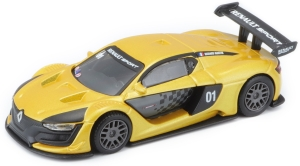

In [229]:
from IPython.display import Image
Image(filename = get_fsn_image_path(fsn_meta.fsn[12]), width=300, height=300)

In [228]:
print("# of imgs downloaded: {}".format(len(os.listdir(images_dir))))

# of imgs downloaded: 60371


### Fill missing images with white

In [227]:
from PIL import Image, ImageDraw
def find_corrupt_image_fsns(fsns):
    for fsn in fsns:
        try:
            Image.open(get_fsn_image_path(fsn))
        except IOError:
            yield fsn
null_image_fsns=list(find_corrupt_image_fsns(fsn_meta.fsn.tolist()))
print("bad fsns were: {}".format(null_image_fsns))
for fsn in null_image_fsns:
    img = Image.new('RGB', (IMAGE_DIM, IMAGE_DIM), "white")
    img.save(get_fsn_image_path(fsn), "JPEG")

bad fsns were: ['9781849081511', '9789384089429', '9781259006210', '9781858943398', '9789384089443', '9780762429776', '9789386021588', 'DDHF4TS6W7BHZPBD', 'STFEMRNHPUSEWTJW', 'BDGDR7C3DXJFQVGH', 'PBXFYWVJPKBGXVRN', 'STFEG3XGB3Y6YFJV', 'RPTEMZGGZGRQXJZY']


# Find Image embeddings

In [8]:
import tensorflow as tf
import tensorflow_hub as hub

In [9]:
def preprocess_image(image_file, width=224, height=224):
    image_encoded = tf.read_file(image_file)
    image = tf.image.decode_image(image_encoded, channels=3, dtype=tf.float32)
    image = tf.Print(image, [image], message="preprocessing image")
    image_padded = tf.image.resize_image_with_pad(image, target_height=height, target_width=width)
    image_padded.set_shape(shape=(width, height, 3))
    return image_padded

def compute_without_batch(images, module):
    embs = module(images)# tf.map_fn(module, images, back_prop=False)
    return embs.eval()

def compute_with_batch_low(images, module):
    image_batches=tf.train.batch([images], batch_size=10, enqueue_many=True, allow_smaller_final_batch=True)
    tf.train.start_queue_runners()
    return module(image_batches).eval()
    #emb_batches = tf.map_fn(module, image_batches, back_prop=False)
    #return emb_batches.eval()
    
def get_image_embeddings(image_files_list):
    with tf.Graph().as_default():
        # load and batch images
        file_paths_tensor = tf.convert_to_tensor(image_files_list, dtype=tf.string)
        file_paths_queue = tf.train.string_input_producer(file_paths_tensor, num_epochs=1, shuffle=False)
        image_file_path = file_paths_queue.dequeue()
        image = preprocess_image(image_file_path)

        images=tf.train.batch([image], batch_size=1000, allow_smaller_final_batch=True)

        # load module
        NASNET_MOBILE='https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/1'
        module = hub.Module(NASNET_MOBILE)
        tf.logging.info('module loaded')
        #expected_width, expected_height= hub.get_expected_image_size(module)

        embs = module(images)
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        with tf.Session(config=config) as sess:
            sess.run(tf.local_variables_initializer())
            sess.run(tf.global_variables_initializer())
            sess.run(tf.tables_initializer())
            tf.logging.info('globals initiated')
            
            tf.train.start_queue_runners()
            
            embs_list = []
            try:
                while True:
                    _embs = embs.eval()
                    tf.logging.info(_embs.shape)
                    embs_list.append(_embs)
            except tf.errors.OutOfRangeError:
                tf.logging.info('all embs computed')
            sess.close()
            return np.vstack(embs_list)

def get_fsns_embeddings(fsns):
    fsn_images = [get_fsn_image_path(fsn) for fsn in fsns]
    return get_image_embeddings(fsn_images)

embs=get_fsns_embeddings(fsn_meta.fsn.tolist())

Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:module loaded
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:globals initiated
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO:tensorflow:(1000, 1056)
INFO

In [10]:
embs.tofile(osp.join(save_dir, 'fsn_embs.pk'))

# Nearest Neighbour

In [30]:
%%time
from annoy import AnnoyIndex

t = AnnoyIndex(embs.shape[1], metric='dot')  # Length of item vector that will be indexed    
fsn_meta.apply(lambda x: t.add_item(x.name, embs[x.name]), axis=1)
t.build(10) # 10 trees
nn_tree_path=osp.join(save_dir, 'nn.ann')
t.save(nn_tree_path)

True

In [31]:
u = AnnoyIndex(embs.shape[1])
u.load(nn_tree_path) # super fast, will just mmap the file

True

In [ ]:
DBG_FSN=np.random.randint(fsn_meta.shape[0])
nn_fsns=fsn_meta.iloc[u.get_nns_by_item(DBG_FSN, 10)].fsn.values
plot_images(nn_fsns)

In [40]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib

def plot_images(fsns):
    imgs=[mpimg.imread(get_fsn_image_path(f)) for f in fsns]
    N_COLS=5
    N_ROWS=(len(fsns)+N_COLS-1)//N_COLS
    PLOT_WIDTH=17
    PLOT_HEIGHT=1.5*int(N_ROWS*(PLOT_WIDTH/N_COLS))
    f, axarr = plt.subplots(N_ROWS, N_COLS, squeeze=False, figsize=(PLOT_WIDTH,PLOT_HEIGHT))
    [(ax.get_xaxis().set_visible(False), ax.get_yaxis().set_visible(False), ax.axis('off')) for ax in f.axes]
    
    f.tight_layout()
    for idx, fsn in enumerate(fsns):
        plt.axis('off')
        plot_row = idx//N_COLS
        plot_col = idx%N_COLS
        axarr[plot_row,plot_col].imshow(imgs[idx])
        title=fsn_meta[fsn_meta.fsn==fsns[idx]].iloc[0].title
        axarr[plot_row,plot_col].set_title(title)
    #plt.savefig('similar_demo_3.png')
    plt.show()